In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
from tqdm import tqdm

import inference.scheduler
from inference.distribution import Gaussian, Rosenbrock, InterpolatedDensity
from inference.sde import EulerMaruyamaSimulator, LangevinDynamics
import utils.vis2d.visualization

/Users/clarkmiyamoto/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


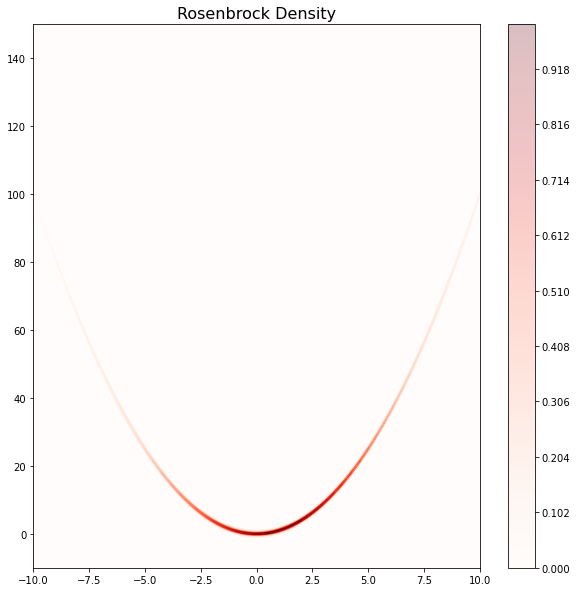

In [2]:
# Distribution
distribution = Rosenbrock()
density_field = lambda x: torch.exp(distribution.log_density(x))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # Ensure square figure size
x_bounds, y_bounds = (-10, 10), (-10, 150)
utils.vis2d.visualization.visualize_contours_scalarfield(
    density_field,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    ax=ax,
    bins=500,
    device=device,
    alpha=0.25, cmap=plt.get_cmap('Reds'),
    show_colorbar=True,
)
ax.set_title('Rosenbrock Density', fontsize=16)
plt.show()

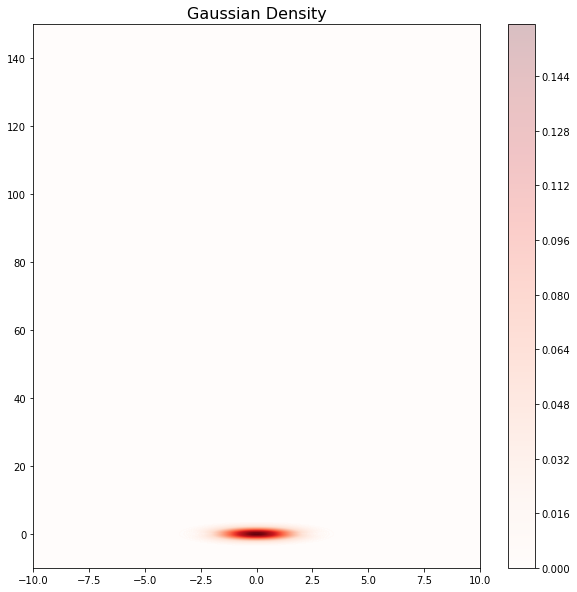

In [3]:
# Distribution
distribution = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density_field = lambda x: torch.exp(distribution.log_density(x))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # Ensure square figure size
x_bounds, y_bounds = (-10, 10), (-10, 150)
utils.vis2d.visualization.visualize_contours_scalarfield(
    density_field,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    ax=ax,
    bins=500,
    device=device,
    alpha=0.25, cmap=plt.get_cmap('Reds'),
    show_colorbar=True,
)
ax.set_title('Gaussian Density', fontsize=16)
plt.show()

# Linear Interpolation of Scores

In [4]:
class LinearInterpolatedDensity(InterpolatedDensity):

    def __init__(self, density0, density1):
        super().__init__(density0, density1)
    
    def interpolate(self, log_density0: torch.Tensor, log_density1: torch.Tensor, alpha: float) -> torch.Tensor:
        """
        Constructs interpolation between density0 and density1
        Args:
            - log_density0 (torch.Tensor): Log density of density0 evaluated at x
            - log_density1 (torch.Tensor): Log density of density1 evaluated at x
            - alpha (float): Interpolation parameter (0 <= alpha <= 1)
        """
        return log_density0 + alpha * (log_density1 - log_density0)

In [ ]:
import torch
import matplotlib.pyplot as plt

from inference.distribution import InterpolatedDensity
from inference.simulator import Simulator

def run(dist: InterpolatedDensity, 
        x: torch.Tensor, 
        ts: torch.Tensor,
        noise_scheduler: inference.scheduler.Scheduler,
        interpolant_steps: torch.Tensor) -> torch.Tensor:    
    # Run Simulation
    xs = [x.clone()] 
    for step_pct in tqdm(interpolant_steps):
        score = lambda x, _: dist.score(x, alpha=step_pct)
        sde = LangevinDynamics(score=score, 
                               noise_scheduler=noise_scheduler)
        simulator = EulerMaruyamaSimulator(sde=sde)
        x = simulator.simulate(x=x, ts=ts) # shape (batch_size, dim)
        xs.append(x.clone())
    return torch.stack(xs, dim=1) # Shape (batch_size, interpolant_steps, dim)

def plot_trajectories_2d(x0: torch.Tensor,  
                         timesteps: torch.Tensor,
                         density: InterpolatedDensity,
                         noise_scheduler: inference.scheduler.Scheduler,
                         interpolant_steps: torch.Tensor,
                         x_bounds,
                         y_bounds,
                         show_num_steps: int = 5,):
    # Simulate Trajectories
    trajectories = run(dist=density, 
                       x=x0, 
                       ts=timesteps, 
                       noise_scheduler=noise_scheduler,
                       interpolant_steps=interpolant_steps) # Shape (batch_size, num_timesteps, dim)

    # Find slices to plot
    indices = torch.linspace(0, len(interpolant_steps)-1, show_num_steps, dtype=int)

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=show_num_steps, figsize=(30, 30))
    for i, ax in enumerate(axes):
        index = indices[i]
        t = interpolant_steps[index]
        
        # Subplot settings
        ax.set_title(f"t = {t:.2f}")
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Plot Current position of samples
        x = trajectories[:, index, 0]
        y = trajectories[:, index, 1]
        ax.scatter(x=x, y=y, alpha=0.9, s=10.0)

        # Plot Density
        logprob = lambda x: torch.exp(density.log_density(x, alpha=t))
        utils.vis2d.visualization.visualize_contours_scalarfield(
            logprob,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            ax=ax,
            bins=100,
            device=device,
            alpha=0.25, cmap=plt.get_cmap('Reds'),
            show_colorbar=True,
        )
        
        # Plot Vector Field
        score = lambda x: density.score(x, alpha=t)
        utils.vis2d.visualization.visualize_vectorfield(vectorfield=score,
                                                        x_bounds=x_bounds,
                                                        y_bounds=y_bounds,
                                                        num_arrows=20,
                                                        ax=ax)
    return fig, axes



In [ ]:
### Setup
# Distribution Setup
nmodes = 5
std = 1.0
scale = 20.0
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = Rosenbrock()

# Simulator setup
noise_scheduler = inference.scheduler.Linear(3.0, 0.5)
x0 = density0.sample(num_samples=100)
# interpolant_steps = torch.tensor([0.25, 0.35, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.955, 0.975, 1.0])
interpolant_steps = torch.tensor([0.25, 1.0])
num_steps, step_size = 1000, 0.01
ts = torch.arange(0, num_steps * step_size, step_size)

# Training Setup



### Code
# Setup up
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

fig, axes = plot_trajectories_2d(x0=x0, 
                                 timesteps=ts, 
                                 density=dist_interpolated,
                                 noise_scheduler=noise_scheduler,
                                 interpolant_steps=interpolant_steps,
                                 x_bounds=[-scale * 0.75, scale * 0.75],
                                 y_bounds=[-scale * 0.75, scale * 0.75],)
fig.suptitle(f"Interpolated Density Trajectories: {nmodes} Modes")
plt.show()

100%|██████████| 2/2 [00:04<00:00,  2.03s/it]
